# Inverse scattering for circular billiard

## Importação das bibliotecas

In [66]:
import numpy as np
import scipy
import scipy.special as sc
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

## Lendo os dados

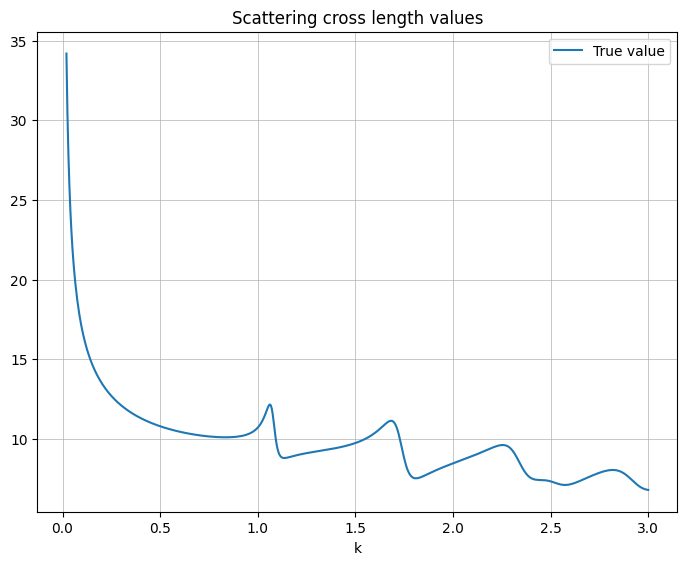

In [18]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(k, l_array, ls='-', label="True value")
axes.set_title(f'Scattering cross length values')
axes.set_xlabel(f'k')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

## Definição dos inputs da rede

In [19]:
inputs_array = np.array([])
inputs_array = np.append(inputs_array, [M, HBAR, k_min, k_max, delta_k, n_max])
inputs_array = np.append(inputs_array, l_array)

print(len(inputs_array))

num_samples = 602
output_size = 2
inputs_array = inputs_array.reshape(-1, 1)  # Reshape to (1, 603)

print(inputs_array.shape)

# inputs_array = np.random.rand(num_samples, inputs_array)  # Shape (100, 603)
targets_array = np.random.rand(num_samples, output_size) * 2  # Example target data

# targets_array = np.transpose(targets_array)

# targets_array = targets_array.reshape(-1, 1)
print(targets_array.shape)


602
(602, 1)
(602, 2)


## Implementação da rede neural

### Definição da rede neural

A rede neural implementada é uma rede neural do tipo Multilayer Perceptron

In [20]:
def calculate_hidden_neurons(input_size, output_size):
    # Rule 1: The number of hidden neurons should be between the size of the input layer and the size of the output layer
    rule_1 = max(input_size, output_size)
    
    # Rule 2: The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer
    rule_2 = int(2/3 * input_size + output_size)
    
    # Rule 3: The number of hidden neurons should be less than twice the size of the input layer
    rule_3 = min(2 * input_size - 1, input_size + input_size // 3)
    
    # The number of hidden neurons should be the minimum that satisfies all rules
    hidden_neurons = min(rule_1, rule_2, rule_3)

    print(hidden_neurons)
    return hidden_neurons

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        hidden_neurons = calculate_hidden_neurons(input_size, output_size)
        
        self.hidden_layer = nn.Linear(input_size, hidden_neurons)
        self.output_layer = nn.Linear(hidden_neurons, output_size)
        self.sigmoid = nn.Sigmoid()

    # def add_hidden_layer(self):
    #     # Determine the size of the new hidden layer
    #     if len(self.hidden_layers) == 0:
    #         hidden_size = calculate_hidden_neurons(self.input_size, self.output_size)
    #         new_layer = nn.Linear(self.input_size, hidden_size)
    #     else:
    #         prev_hidden_size = self.hidden_layers[-1].out_features
    #         hidden_size = calculate_hidden_neurons(prev_hidden_size, self.output_size)
    #         new_layer = nn.Linear(prev_hidden_size, hidden_size)
    #     self.hidden_layers.append(new_layer)
    
    def forward(self, x):
        x = self.sigmoid(self.hidden_layer(x))
        x = self.sigmoid(self.output_layer(x))
        return x

In [21]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Loss: {val_loss/len(val_loader)}')

In [22]:
def evaluate_model(model, criterion, test_loader):
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(test_loader)}')

### Variáveis para o modelo, separação dos dados de teste e treino e etc

In [23]:
train, test_data = train_test_split(inputs_array, test_size = 0.2, random_state = 2)
real_train_data, validation_data = train_test_split(train, test_size = 0.3, random_state = 2)

train_target, test_target = train_test_split(targets_array, test_size = 0.2, random_state = 2)
real_train_target, validation_target = train_test_split(train_target, test_size = 0.2, random_state = 2)

real_train_data = np.transpose(real_train_data)
validation_data = np.transpose(validation_data)
test_data = np.transpose(test_data)

input_size = len(inputs_array)
output_size = 2
batch_size = 100
num_epochs = 200
learning_rate = 0.001

data_train = torch.tensor(real_train_data, dtype=torch.float32)
target_train = torch.tensor(real_train_target, dtype=torch.float32)

data_val = torch.tensor(validation_data, dtype=torch.float32)
target_val = torch.tensor(validation_target, dtype=torch.float32)

data_test = torch.tensor(test_data, dtype=torch.float32)
target_test = torch.tensor(test_target, dtype=torch.float32)

print("Input Shapes:")
print(data_train.shape, data_val.shape, data_test.shape)
print("Target Shapes:")
print(target_train.shape, target_val.shape, target_test.shape)

Input Shapes:
torch.Size([1, 336]) torch.Size([1, 145]) torch.Size([1, 121])
Target Shapes:
torch.Size([384, 2]) torch.Size([97, 2]) torch.Size([121, 2])


In [24]:
# Data Loaders
train_dataset = torch.utils.data.TensorDataset(data_train, target_train)
val_dataset = torch.utils.data.TensorDataset(data_val, target_val)
test_dataset = torch.utils.data.TensorDataset(data_test, target_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

AssertionError: Size mismatch between tensors

In [ ]:
model = MLP(input_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)
evaluate_model(model, criterion, test_loader)